<a href="https://colab.research.google.com/github/ivaaanrm/CVDL/blob/main/CVDL_Lines_1_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MET Computer Vision with Deep Learning**
# **Lab1 - Line detection**

2024 - Josep Ramon Morros - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group // [ETSETB – UPC.TelecosBCN](https://telecos.upc.edu/ca)


---

### Write here your name

**Name**:

---

### **Introduction**

This practical work has two objectives: first, to analyze the operation of some low-level algorithms. Second, to use these tools to solve practical problems.

As we will be using a deep learning method, we will configure Colab to use a GPU for faster operation:

Runtime --> Change runtime type --> Hardware acceleration: GPU

We will be using the some additional images and videos. First of all download the file cvdl_l1.zip from ATENEA and upload it to the Colaboratory notebook using the menu on the left (click the folder icon,  upload the cvdl_l1.zip file). **Wait until the upload is complete**, it may take a long time.


*Decompress* the zip file to use its contents:`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CVDL/cvdl_l1.zip -d /content/drive/MyDrive/CVDL

Archive:  /content/drive/MyDrive/CVDL/cvdl_l1.zip
   creating: /content/drive/MyDrive/CVDL/cvdl_l1/
   creating: /content/drive/MyDrive/CVDL/cvdl_l1/video/
  inflating: /content/drive/MyDrive/CVDL/cvdl_l1/video/traffic_camera.mp4  
   creating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/
   creating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/images/
  inflating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/images/cat.jpg  
  inflating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/images/janie.jpg  
  inflating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/images/guitar.jpg  
  inflating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/detect_edges_video.py  
   creating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/hed_model/
  inflating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/hed_model/deploy.prototxt  
  inflating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/hed_model/hed_pretrained_bsds.caffemodel  
  inflating: /content/drive/MyDrive/CVDL/cvdl_l1/hed/detect_edges_image.py  
  inflating: /content/drive/MyDrive/CVDL/cv

In [ ]:
BASE_PATH =

### **Pre-processing**

The following video has been captured by a traffic surveillance camera.

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Extracted from https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab
mp4 = open('cvdl_l1/video/traffic_camera.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
def plot_images(images, titles, cols=3, figsize=(12, 8), cmap='gray'):
    """
    Displays a list of images with titles in a grid format.

    Parameters:
        images (list): List of images to display.
        titles (list): List of titles corresponding to the images.
        cols (int): Number of columns in the grid (default: 3).
        figsize (tuple): Figure size (default: (12, 8)).
        cmap (str): Colormap for displaying images (default: 'gray').
    """
    rows = -(-len(images) // cols)  # Ceiling division to determine rows
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Flatten axes in case of multiple rows
    axes = np.array(axes).flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap=cmap)
            ax.set_title(titles[i])
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots if images < grid size

    plt.tight_layout()
    plt.show()

Let's define a useful function to display images:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import filters
from scipy.stats import mode
import cv2

import sys
from pathlib import Path

sys.path.append("/content")


from cvdl_l1.code.display_images import display_image, display_images

ImportError: cannot import name 'display_images' from 'cvdl_l1.code.display_images' (/content/cvdl_l1/code/display_images.py)


We are interested in detecting the lines that separate the road lanes. The problem here is that the passing cars make it difficult to see the lines. For this, we will try to obtain an image of the background (the road) without the cars. If we look at the color of a given pixel of the road along the video sequence, we will see that in the majority of the frames of the video sequance, the pixel will have the color of the road, and only in a few frames  the color of a car because the cars move very fast and the road is static.

Now, we will average a large number of frames (for instance, 100) and we will examine the average image:

In [ ]:
cap = cv2.VideoCapture('cvdl_l1/video/traffic_camera.mp4')

ff = True
# Define a 3D matrix to store the 100 images
# The video is 640x360

# Create an empy image of 360 rows and 640 columns, with 100 channels.
allfr = np.zeros((100,360,640))

# Loop over frames from the video stream and accumulate
# all frames in a single variable
for ii in range(100):

    if ii%10 == 0:
      print ('Processing frame {}'.format (ii))
    ret,frame = cap.read() # read the vieo frame

    if ret is False: # If something failed ...
        break

    # convert the frame to grayscale,
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Store the frame in the matrix
    allfr[ii,:,:] = gray

# Average the 100 frames.
avg = np.average(allfr,axis=0)

# Convert to uint8 data type
avg = avg.astype(np.uint8)

Processing frame 0
Processing frame 10
Processing frame 20
Processing frame 30
Processing frame 40
Processing frame 50
Processing frame 60
Processing frame 70
Processing frame 80
Processing frame 90


Let's display the result:

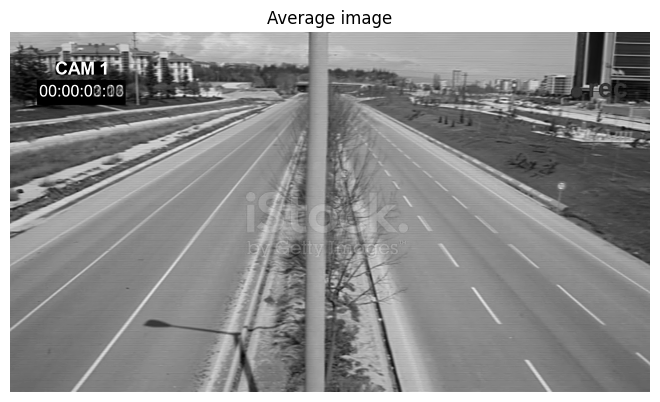

In [ ]:
display_image(avg, 'Average image', size=1)


We can also compute the [mode](https://en.wikipedia.org/wiki/Mode_(statistics)) of the 100 frames. This is, for each pixel, the gray level value that occurs more times along the 100 frames.

(360, 640)
(100, 360, 640)


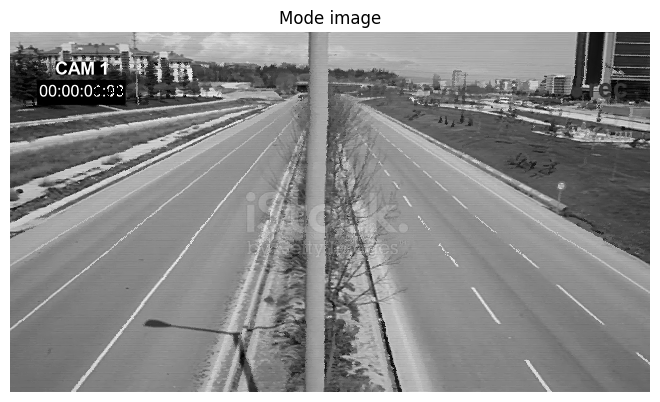

In [ ]:
print(avg.shape)
print(allfr.shape)

mde  = mode(allfr,axis=0)[0].astype(np.uint8)
display_image(mde, 'Mode image', size=1)

Comment the results in both cases. Explain why the cars have dissapeared from the image.

<font color=red>**Q1: Answer**:  </font><br>
<font color=blue>

- In both images, the cars have disappeared. In the average image, this happens because each pixel value is averaged over multiple frames. As a result, fast-moving objects, such as cars, do not appear since they occupy different positions in each frame, and their contributions are diluted.

- In the mode image, a similar effect occurs, but for a different reason. Here, the most frequently occurring pixel values are selected. Since moving objects change position across frames, they are less likely to be the most common values, and thus they are not included in the final image.

We can also observe that the average image has better quality than the mode image. The road lines appear smoother and less distorted, likely because averaging reduces noise and variations, whereas the mode approach may introduce artifacts due to discrete pixel selection.

</font>

Note that in the images are in fact matrices. Most Computer Vision libraries use numpy arrays to represent images. Let's examine image **avg**. We can know its dimensions. For this we will use the shape property of the array:

In [ ]:
mde.shape

(360, 640)

As we can see, the image is two dimensions (gray level). The number of rows is 360 and the number of columns is 640. We can access any pixel to know its value: or to change it:

In [ ]:
mde[0][0]


177

In [ ]:
mde[0][0] = 25
mde[0][0]

25

However ins most cases, it is more practical to use library functions to deal with images. OpenCV and scikit-image are examples of computer vision libraries. There are many others (bob, glib, etc.). In the previous examples we have used several of these functions: np.average(), cv2.imread(), etc.

### **Edge detection:**

Perform edge detection on image **avg** using three different methods: thresholding of the gradient (Sobel), Canny, and a deep learning method, Holistically Nested Edge Detection [1].

[1] Saining Xie, Zhuowen Tu, "Holistically-Nested Edge Detection", arXiv:1504.06375



**Important note**: resizing (downsampling) the resulting contour images for visualization may affect the contour image contents. Some contours may be removed by the downsampling process. To avoid this always  visualize contour images at 100% (use size=1 in display_image) or downsample the images BEFORE contour detection.

Compute contours using a binarization of the gradient. Adjust the binarization threshold (threshold_sobel) so that the lane separation lines are correctly detected, with the minimum amount of 'unwanted' contours as possible. Unwanted contours are those that are not lane lines.

In [ ]:
# Compute edges using sobel magnitude
edges = filters.sobel(avg)

# Maximum value of the gradient image.
# The threshold should be between zero and this value
print (np.max(edges))


0.7568151209236947


In the next code cell, select the most approriate value for threshold_sobel, a threshold on the magnitude of the gradient at each point. Fill the parts marked with TODO. Please, leave the # TODO comments in the modified code.

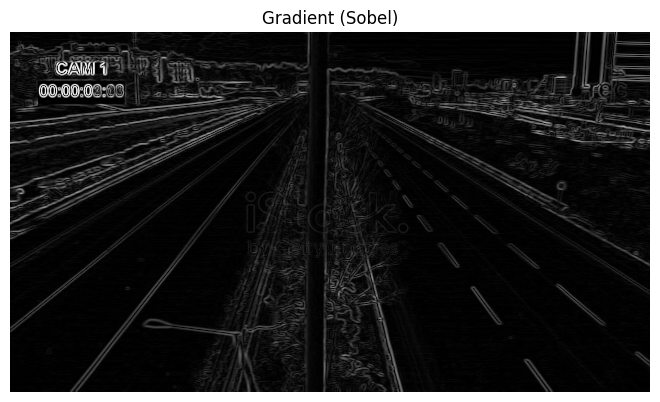

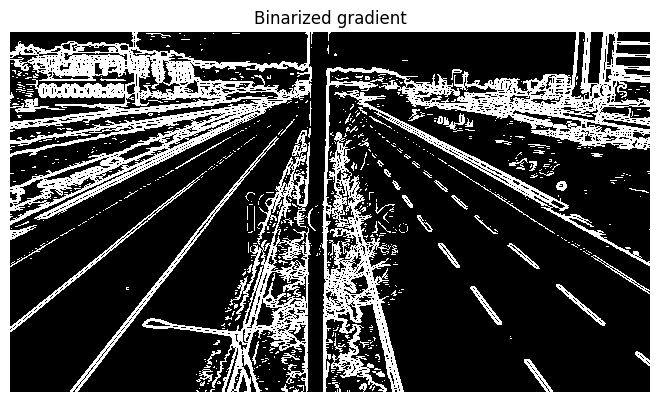

In [ ]:
# Threshold. Select the most approriate value for threshold_sobel, a threshold
# on the magnitude of the gradient at each point.
threshold_sobel = 0.06 # TODO 1
ret, im_bw  = cv2.threshold(edges, threshold_sobel, 255, cv2.THRESH_BINARY)
display_image(edges, 'Gradient (Sobel)', size=1)
display_image(im_bw, 'Binarized gradient', size=1)

Now, let's compute edges usign Canny with custom parameters. We will use different sets of values for sigma, low_threshold and high_threshold to demonstrate the effect of changing each of these values.

Remember that increasing the value of sigma makes the contours weaker, so that you will have to lower the values of high_threshold and low_threshold accordingly.

Finally, adjust the parameters so that the lane separation lines are correctly detected, with the minimum amount of 'unwanted' contours as possible, Unwanted contours are those that are not lane lines.

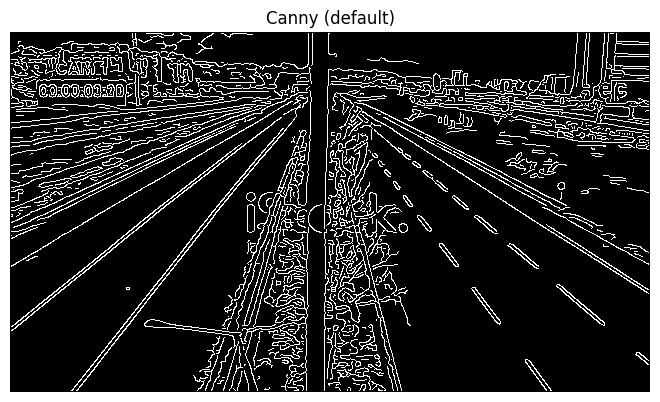

In [ ]:
# Compute edges using canny with automatic/default parameters
edges = feature.canny(avg)
display_image(edges, 'Canny (default)', size=1)

In the next code cell, try different values for the sigma parameter and explain the effect of increasing its value.

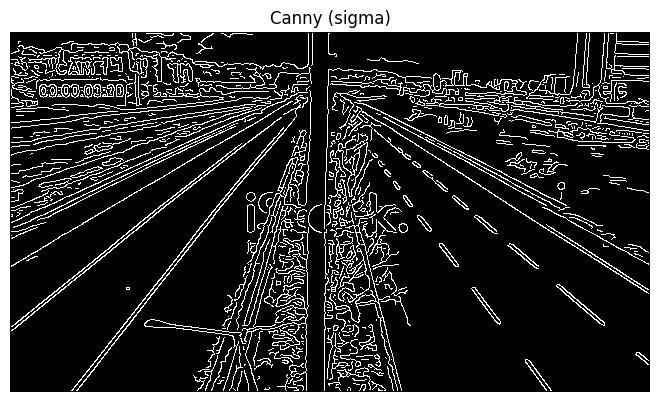

In [ ]:
# Compute edges using canny with custom parameters. See the effect of increasing sigma.
sigma          = 1
low_threshold  = 25 # Default value
high_threshold = 51 # Default value
edges = feature.canny(avg, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
display_image(edges, 'Canny (sigma)', size=1)

Comment the effect of incresing sigma.

<font color=red>**Q2: Answer**:  </font><br>
<font color=blue>

Increasing `sigma` applies stronger Gaussian smoothing, reducing noise but also weakening fine details. This requires lowering `low_threshold` and `high_threshold` to retain important edges.

</font>

In the next code cell, adjust thresholds to improve detection of lane lines

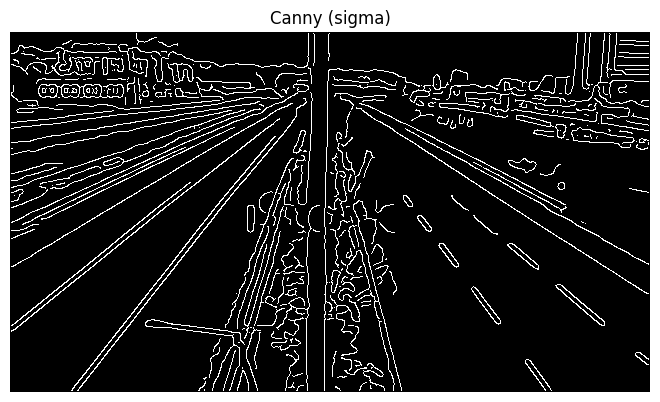

In [ ]:
# Compute edges using canny with custom parameters. Adjust thresholds to improve detection of lane lines.
sigma          = 2
low_threshold  = 20 # TODO 2
high_threshold = 40 # TODO 2
edges = feature.canny(avg, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
display_image(edges, 'Canny (sigma)', size=1)

In the next code cell, try different values for the low_threshold parameter and comment the effect of setting a very low velue for low_threshold. Hint: look for contours that should not be present

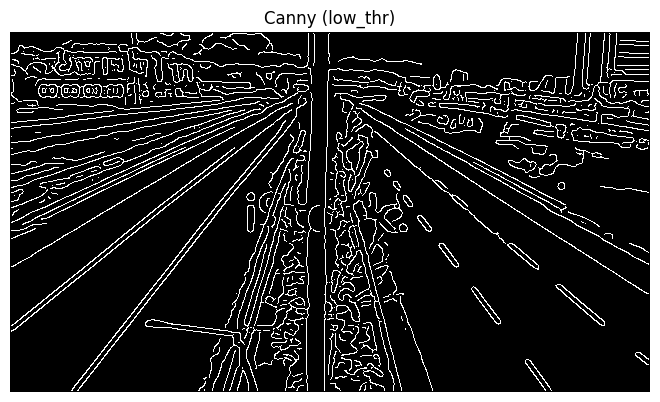

In [ ]:
# Comment the effect of setting a very low velue for low_threshold.
# Hint: look for contours that should not be present
sigma          = 2
low_threshold  = 6
high_threshold = 25
edges = feature.canny(avg, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
display_image(edges, 'Canny (low_thr)', size=1)

Comment the effect of using a small value for low_threshold.

<font color=red>**Q3: Answer**:  </font><br>
<font color=blue>
Using a small `low_threshold` makes the Canny edge detector more sensitive, detecting weaker edges. This can help capture faint lane markings but also increases unwanted contours from noise, shadows, and textures.

To balance detection quality, low_threshold should be high enough to reduce false edges while still capturing essential lane lines.</font>

In the next code cell, try different values for the high_threshold parameter and comment the effect of setting a very high value for low_threshold.

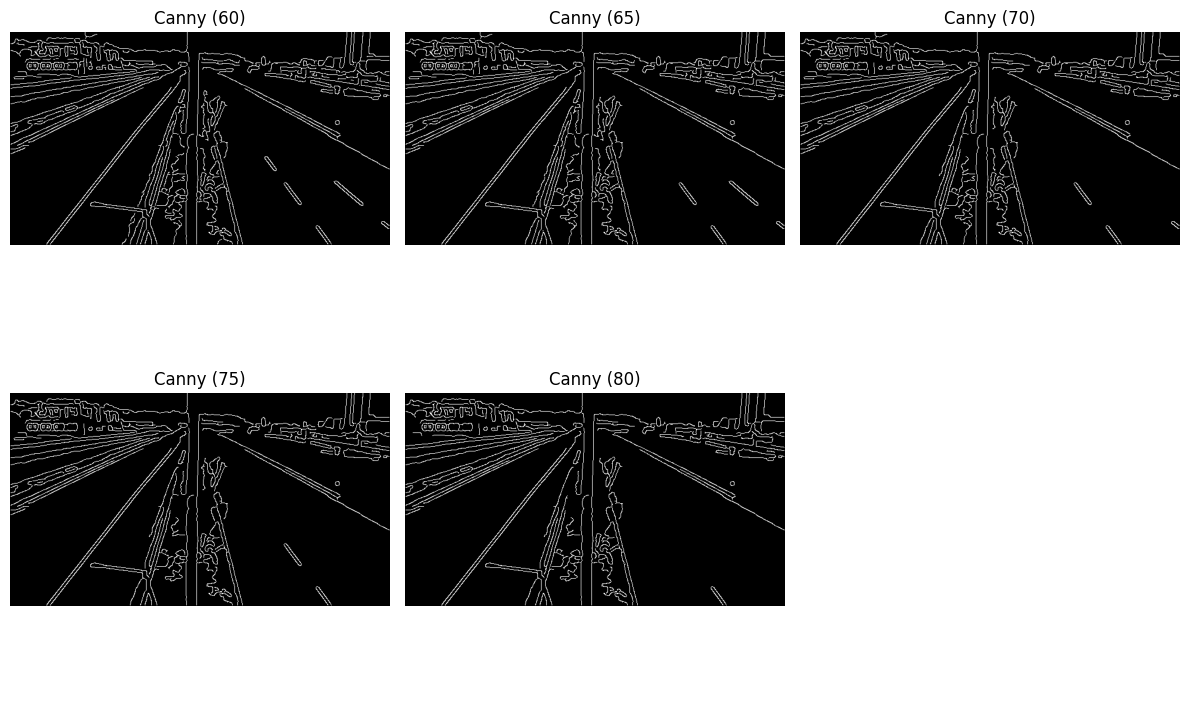

In [ ]:
# Comment the effect of setting a very high velue for high_threshold.
sigma          = 2
low_threshold  = 15
high_threshold = 80

high_ths = [60, 65, 70, 75, 80]

iamges = []

for th in high_ths:
  edges = feature.canny(avg, sigma=sigma, low_threshold=low_threshold, high_threshold=th)
  iamges.append(edges)

titles =

plot_images(iamges, "Canny (high_thr)")

#edges = feature.canny(avg, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
#display_image(edges, 'Canny (high_thr)', size=1)

Comment the effect of using a large value for high_threshold.

<font color=red>**Q4: Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

In the next code cell, Select the best parameters you can obtain. Try to preserve lane lines and to remove other contours.

In [ ]:
# Select the best parameters you can find. Preserve lane lines and try to remove other contours.
sigma          = # TODO 3
low_threshold  = # TODO 3
high_threshold = # TODO 3
edges = feature.canny(avg, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
display_image(edges, 'Canny (high_thr)', size=1)

Compute edges usign HED. HED does not provide a method for thinning the contours. The function thin_contours() implements a thinning method inspired in the Canny approach: Non-maxima suppression plus contour tracking using hysteresis. Select a good choice of values for low_threshold and high_threshold so that you are satisfied with the result (there is not a unique valid solution).

In [ ]:
from cvdl_l1.hed.hed_detect import hed_detect
from cvdl_l1.code.contour_functions import thin_contours

avg = cv2.cvtColor(avg,cv2.COLOR_GRAY2RGB)
edges6   = hed_detect(avg)
display_image(edges6, 'HED', size=1)

In [ ]:
# Adjust parameters:
low_threshold4  = # TODO 4
high_threshold4 = # TODO 4
bw_image = thin_contours(edges6, low_threshold4, high_threshold4)
display_image(bw_image, 'HED (thin cont.)', size=1)

Compare the results for the three methods (gradient thresholding, Canny and HED) in terms of performance and simplicity of use. Comment the effects of the parameters on each method.

<font color=red>**Q5: Answer**:  </font><br>
<font color=blue>
 (answer here)
</font>

### **Line detection with Hough**
We will use the Hough transform functions to extract the parameters of the lane lines. You should look at the [example](http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html) and to the [reference](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line) for more information on how the functions work.

Now let's compute the lines parameters and display the **avg** image with these contours superimposed:

In [ ]:
from skimage.transform import (hough_line, hough_line_peaks)

# Definition of the angles to test. We compute the HT in steps of 1º
tested_angles = np.linspace(-np.pi/2,np.pi/2,180)

h, theta_vect, d = hough_line(edges, theta=tested_angles)

# Set the threshold to discard lines with few points. The threshold
# is the number of contour points of each line
thr = 0.5*np.max(h) # This is the default value

# Display the lines found:
out = avg.copy() # Create a version of the average image to display the lines
for _, theta, rho in zip(*hough_line_peaks(h, theta_vect, d, threshold=thr)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    # Create two points of the line outside the image so that the line
    # traverses all the image
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(out,(x1,y1),(x2,y2),(0,0,255),2)

display_image(out, 'Detected lines', size=1)

In the results image, we can see that many unwanted  lines are detected. This happens because the functions returns all peaks in the Hough space. To remove the unwanted lines, we have several options:

1. The first option is to set a higher threshold in the hough_line_peaks function. This will cause that only most important peaks, representing lines with many pixels, to be detected.

> Select a threshold so that you recover as many lane lines as possible with the smallest amount of unwanted lines.

In [ ]:
# Definition of the angles to test. We compute the HT in steps of 1º
tested_angles = np.linspace(-np.pi/2,np.pi/2,180)

h, theta_vect, d = hough_line(edges, theta=tested_angles)

# Set the threshold to discard lines with few points. The threshold
# is the number of contour points of each line
thr = # TODO 5

# Display the lines found:
out = avg.copy() # Create a version of the average image to display the lines
for _, theta, rho in zip(*hough_line_peaks(h, theta_vect, d, threshold=thr)):
    a  = np.cos(theta)
    b  = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    # Create two points of the line outside the image so that the line
    # traverses all the image
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(out,(x1,y1),(x2,y2),(0,0,255),2)

display_image(out, 'Detected lines', size=1)

2. Another solution in this case is to use a mask to define the region of interest. As the traffic camera is static and we are interested only in the information in the traffic lanes, we can construct a mask to remove the unwanted contours. The mask can be defined by hand, by looking at the **avg** image computed previously. Let's load and visualize a predefined mask:

In [ ]:
from skimage.transform import (hough_line, hough_line_peaks)

# Load the image defining the mask
roi_mask = cv2.imread('cvdl_l1/image/traffic_camera_mask.png')
roi_mask = cv2.cvtColor(roi_mask, cv2.COLOR_BGR2GRAY)

display_image(roi_mask*255, 'ROI mask', size=1)

>Let's apply the ROI mask to the contour image. The
pixels of the regions of interest (the two lanes) have values 1. The pixels of the rest of the image have values 0. When multiplying pixelwise the contour image and the mask, the effect is to delete the regions outside the lanes.

In [ ]:
edges = edges * roi_mask
display_image(edges, 'Simplified contours', size=1)

>Now, we can repeat again the process. We expect that a lot of lines will not appear as the contour points that originated them have been removed. As previously, select the threshold to maximize results.

In [ ]:
# Definition of the angles to test. We compute the HT in steps of 1º
tested_angles = np.linspace(-np.pi/2,np.pi/2,180)

h, theta_vect, d = hough_line(edges, theta=tested_angles)

# Set the threshold to discard lines with few points. The threshold
# is the number of contour points of each line
thr = # TODO 6

# Display the lines found:
out = avg.copy() # Create a version of the average image to display the lines
for _, theta, rho in zip(*hough_line_peaks(h, theta_vect, d, threshold=thr)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    # Create two points of the line outside the image so that the line
    # traverses all the image
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(out,(x1,y1),(x2,y2),(0,0,255),2)

display_image(out, 'Detected lines', size=1)

>Depending on the selected threshold, yoy may find an unwanted line caused by the street lamp in the lower part of the image. The third method will make sure that this does not appear.

3. The last method consists on restrict the computation of the Hough transform to a certain angles. We can see that the lines of interest appear only in two triangular regions of the image (the regions of the left and right roads). As it can be seen in the next figure, the angles of the lane lines can not take all the values between $[0-360)$. They are restricted between two zones defined by, [$\alpha, \beta]$ and $[-\beta,-\alpha]$. Note that in scikit-image, the angles are defined between $-\pi/2$ and $\pi/2$

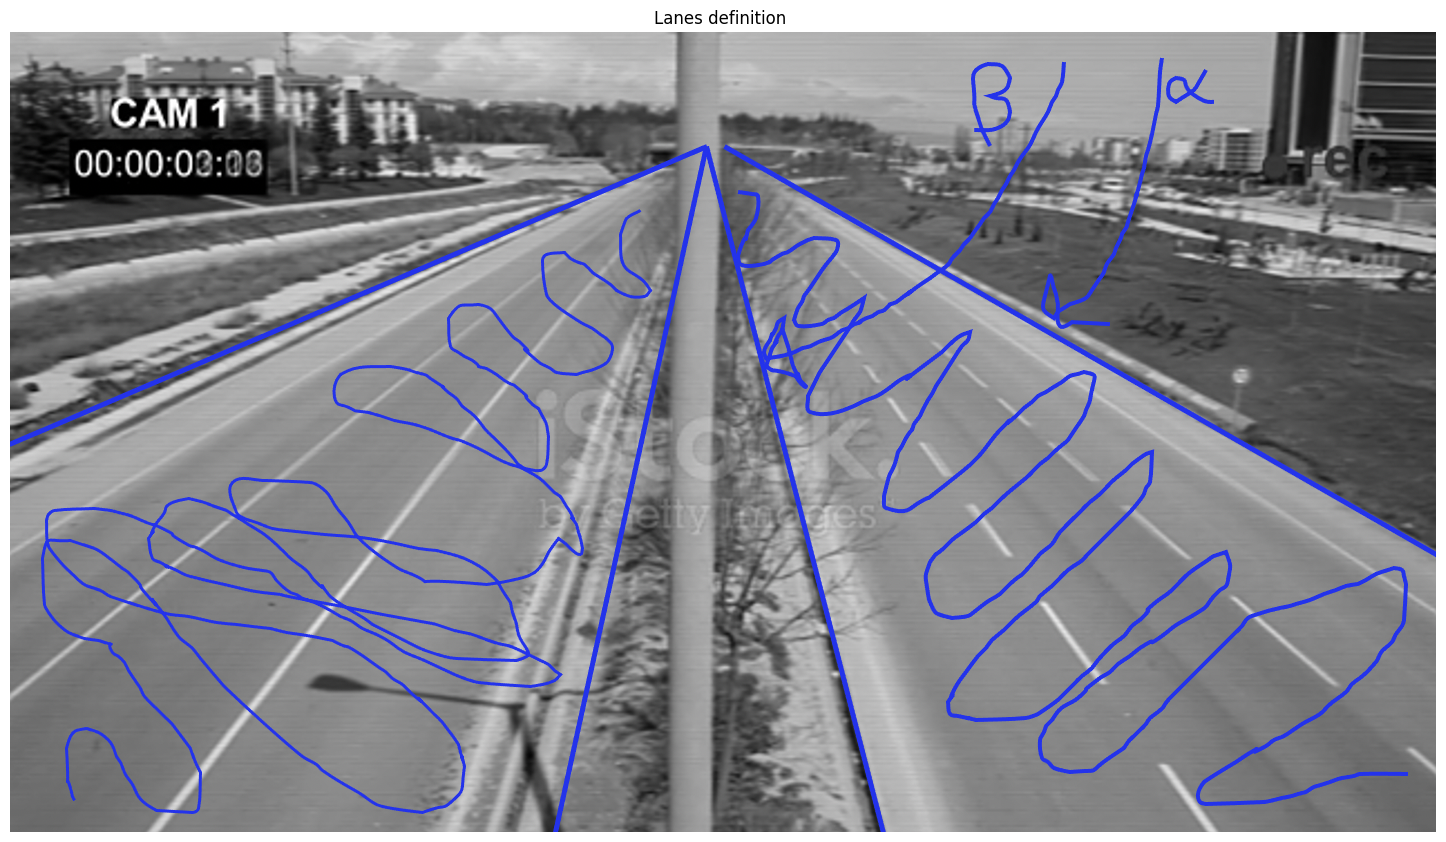

In [ ]:
# Load the image defining the angles
regions_angles = cv2.imread('cvdl_l1/image/angles.png')
display_image(regions_angles, 'Lanes definition ', size=1)

>If we look at the Hough transform pseudocode:
```
	for each edge point (x, y) {
	    // Compute parameters
		for (θ = 0; θ <= θmax; θ = θ+Δθ) {
			ρ = x·cos(θ)+y·sin(θ); // round off to integer (quantization)
			(P[ρ][θ])++;
		}
	}

```
# This is formatted as code
```


```
>we can see that the general solution checks all angles between 0 and $\theta_{max}$, usually, [0 - 360). If we only want to detect lines with specific angles (in our case, the lines with angles compatible with the road lanes) we can modify the foor loop to take this into account. The functions for Hough lines in most Computer vision libraries already support this without having to reimplement the Hough transform. For instance, the hough_lines function in scikit-image:
```
skimage.transform.hough_line(image, theta=None)
```
has a parameter theta that is a list (vector) of all the angles to consider.

>The process will consist of:

>1. Detect contours on the image using one of the above methods (select the optimal parameters)
2. Simplify the contours by applying a Region Of Interest (ROI) mask
3. Create the theta vector with the values between $\alpha$ to $\beta$, $-\beta$ to $-\alpha$ in steps of np.pi/180 rad (1º)
4. Calculate the Hough transform
5. Select the optimal threshold in hough_line_peaks to detect the most important lines in the Hough space.

>The $\alpha$ and $\beta$ angles are determined visually by looking at the image.

>Write code to define the angles to test (tested_angles). Note that you will have to compose two angular spans. Define the threshold thr to display only lines between the lanes.

In [ ]:
# Definition of the angles to test
#tested_angles = np.linspace(-np.pi/2,np.pi/2,180)
tested_angles = # TODO 7
h, theta_vect, d = hough_line(edges, theta=tested_angles)

# Set the threshold to discard lines with few points. The threshold
# is the number of contour points of each line
thr = # TODO 7

# Display the lines found:
out = avg.copy() # Create a version of the average image to display the lines
for _, theta, rho in zip(*hough_line_peaks(h, theta_vect, d, threshold=thr)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    # Create two points of the line outside the image so that the line
    # traverses all the image
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(out,(x1,y1),(x2,y2),(0,0,255),2)

display_image(out, 'Detected lines', size=1)

Comment the results: Give  the values of $\alpha$, $\beta$, and thr. Explain briefly the results.

<font color=red>**Q6: Answer**:  </font><br>
<font color=blue>
$\alpha$ =
<br>
$\beta$ =
<br>
thr =
<br>
<br>
(answer here)
</font>



### **Adjusting lines with RANSAC**

HT1_DEMO.png and HT3_DEMO.png are two synthetic images that simulate the result from an edge or corner detection step. The white pixels in the images represent the contour points. Use RANSAC to obtain the parameters of the lines that best describe the set of points and the number of inliers in each image. Compare with the adjustment obtained directly with the least squares method.

**NOTE**: Each point of the images is composed of multiple pixels to enhance visualization.  



In [ ]:
from sklearn import linear_model

# Noisy 'pseudo-contour' image
im1 = cv2.imread('cvdl_l1/image/HT1_DEMO.png')[:,:,0]
if im1 is None:
  print ('Could not read image')

display_image(im1, 'Points image (with outliers)', size=4)
print (im1.shape)

# Coordinates of the points in image
y1, X1 = np.where(im1 > 0)


# Code partially extracted from :
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html

# Least Squares solution
lr = linear_model.LinearRegression()
lr.fit(X1.reshape(-1,1), y1.reshape(-1,1))

# Fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X1.reshape(-1,1), y1.reshape(-1,1))

# Get the inlier and outlier points
inlier_mask1  = ransac.inlier_mask_
outlier_mask1 = np.logical_not(inlier_mask1)

# Predict data of estimated models
line_X1 = np.arange(X1.min(), X1.max())[:, np.newaxis]
line_y1 = lr.predict(line_X1)
line_y_ransac1 = ransac.predict(line_X1)

# Compare estimated coefficients
print("Estimated coefficients (linear regression, RANSAC):")
print('[{},{}], [{},{}]'.format(lr.coef_[0][0], lr.intercept_[0], ransac.estimator_.coef_[0][0],ransac.estimator_.intercept_[0]))

# Plot the results
lw = 2
plt.scatter(X1[inlier_mask1], y1[inlier_mask1], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X1[outlier_mask1], y1[outlier_mask1], color='gold', marker='.',
            label='Outliers')

plt.plot(line_X1, line_y1, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X1, line_y_ransac1, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.gca().invert_yaxis()
plt.xlim([0,im1.shape[1]])
plt.ylim([im1.shape[1],0])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


im2 = cv2.imread('cvdl_l1/image/HT3_DEMO.png')[:,:,0]
if im2 is None:
  print ('Could not read image')

display_image(im2, 'Points image (no outliers)', size=4)

# Coordinates of the points in image
y2, X2 = np.where(im2 > 0)

# Least Squares solution
lr.fit(X2.reshape(-1,1), y2.reshape(-1,1))
# Fit linear model with RANSAC algorithm
ransac.fit(X2.reshape(-1,1), y2.reshape(-1,1))

# Get the inlier and outlier points
inlier_mask2  = ransac.inlier_mask_
outlier_mask2 = np.logical_not(inlier_mask2)

# Predict data of estimated models
line_X2 = np.arange(X2.min(), X2.max())[:, np.newaxis]
line_y2 = lr.predict(line_X2)
line_y_ransac2 = ransac.predict(line_X2)

# Compare estimated coefficients
print("Estimated coefficients (linear regression, RANSAC):")
print('[{},{}], [{},{}]'.format(lr.coef_[0][0], lr.intercept_[0], ransac.estimator_.coef_[0][0],ransac.estimator_.intercept_[0]))

# Plot the results
lw = 2
plt.scatter(X2[inlier_mask2], y2[inlier_mask2], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X2[outlier_mask2], y2[outlier_mask2], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X2, line_y2, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X2, line_y_ransac2, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.xlim([0,im2.shape[1]])
plt.ylim([im2.shape[1],0])

plt.show()

Comment the results of both images for the Least Squares approach and the RANSAC approach.

<font color=red>**Q7: Answer**:  </font>
<br>
<font color=blue>
 (answer here)
</font>